In [200]:
import pandas as pd
import glob
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community.community_louvain
import community
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import islice
import numpy as np

In [66]:
# remove later
marinas_path = '/Users/mep/Desktop/mep/SocialGraphs/FriendsSentimentAnalysis/episodes'

In [67]:
# remove later
# stella add your path here!!
stellas_path = r'C:\Users\stykaly\OneDrive - DFDS\Documents\GitHub\FriendsSentimentAnalysis\scripts'

In [68]:
# change according to who's working
episodes_path = stellas_path

In [69]:
#input each apisode into a list of str , returns dictionary with episode no as key and script string a value
def make_season_dictionary(episodes_path):
    season_episodes={}
    list_of_episodes = os.listdir( episodes_path)
    for episode in range(228):  # ONLY FOR 1ST SEASON!!
        text_file = open(episodes_path+"/"+list_of_episodes[episode], "r",encoding='utf8')
        episode_script = text_file.read()
        text_file.close()
        season_episodes['{}'.format(f'episode{episode}')]=episode_script
    return season_episodes
    #print(season_episodes)
    
season_dictionary=make_season_dictionary(episodes_path)


In [70]:
#takes a str and splits on Scene, returns list of scenes
def split_episode_scenes(episode_script):
    scenes_of_episode = re.split(r'\[Scene:',episode_script)
    return scenes_of_episode


# takes list as input and extracts list of locations
def locations_finder(scenes_of_episode):
    location_list = []
    for scene in range(1,len(scenes_of_episode)):
        scenes_of_episode[scene]= re.sub(r';',r',',  scenes_of_episode[scene])
        scenes_of_episode[scene]= scenes_of_episode[scene].lower()
        scenes_of_episode[scene]= re.sub(r'rach',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'mnca',r'monica',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chan',r'chandler',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoebebe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'estl',r'estelle',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'rachelel',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'rachele',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'rahcel',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chandlerdler',r'chandler',  scenes_of_episode[scene])
        location = scenes_of_episode[scene].partition(",")[0]
        location_list.append(location)
    return location_list

#takes list as input and extracts list of lists of names of characters, removes duplicates
def character_finder(scenes_of_episode):
    characters_of_scene_list = []
    for scene in range(1,len(scenes_of_episode)):
        character= re.findall('\n[a-zA-Z]+\:',scenes_of_episode[scene])
        for i in range (len(character)):
            character[i] = re.sub(r'\n',r'',character[i])
            character[i] = re.sub(r':',r'',character[i])
        characters_of_scene_list.append(character)
    for scene in range (len(characters_of_scene_list)):
        characters_of_scene_list[scene]= list(dict.fromkeys(characters_of_scene_list[scene]))
    return characters_of_scene_list


In [71]:
##creates a nested dictionary with episodes as keys and a dictionary with scenes as keys and text, location, characters as values
episode_dictionary={}
for episode in list(season_dictionary.keys()):
    list_of_scenes=split_episode_scenes(season_dictionary[episode])
    locations_list=locations_finder(list_of_scenes)
    character_lists=character_finder(list_of_scenes)
    episode_dictionary['{}'.format(episode)]={}
    for i in range (len(list_of_scenes)-1):
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]={}
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['text']=list_of_scenes[i+1]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['location']=locations_list[i]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['characters']=character_lists[i]
   
      

In [72]:
#creates a dataframe out of the episodes_dictionary
our_dataframe=pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in episode_dictionary.items()
    }, 
    axis=0)
our_dataframe

text  \
episode0   scene0    central perk, chandler, joey, phoebe, and mon...   
           scene1    monica's apartment, everyone is there and wat...   
           scene2    the subway, phoebe is singing for chandlerge....   
           scene3    ross's apartment, the guys are there assembli...   
           scene4    a restaurant, monica and paul are eating.]\n\...   
...                                                               ...   
episode227 scene20   joey's apartment. monica has completely destr...   
           scene21   the gate at the airport. the passengers are s...   
           scene22   monica and chandler's apartment. joey, chandl...   
           scene23   ross's apartment. ross enters and checks his ...   
           scene24   monica and chandler's apartment. chandler and...   

                                                             location  \
episode0   scene0                                        central perk   
           scene1                                  monica's apartment   
           scene2                                          the subway   
           scene3                                    ross's apartment   
           scene4                                        a restaurant   
...                                                               ...   
episode227 scene20   joey's apartment. monica has completely destr...   
           scene21   the gate at the airport. the passengers are s...   
           scene22              monica and chandler's apartment. joey   
           scene23   ross's apartment. ross enters and checks his ...   
           scene24   monica and chandler's apartment. chandler and...   

                                                           characters  
episode0   scene0   [monica, joey, chandler, phoebe, all, ross, ra...  
           scene1   [monica, chandler, ross, rachel, phoebe, joey,...  
           scene2                                            [phoebe]  
           scene3                              [ross, joey, chandler]  
           scene4                                      [monica, paul]  
...                                                               ...  
episode227 scene20                           [monica, chandler, joey]  
           scene21                             [ross, phoebe, rachel]  
           scene22                   [monica, chandler, joey, phoebe]  
           scene23                                     [rachel, ross]  
           scene24     [monica, ross, rachel, joey, chandler, phoebe]  

[3050 rows x 3 columns]

In [73]:
our_dataframe.to_csv('Friends_dataframe.csv', index=True)

In [74]:
## sorts characters alphabetically in the dataframe
for item in our_dataframe['characters']:
    item=item.sort()

In [75]:
# Creates dataframe with all the links
df_links = pd.DataFrame(columns=['nodes','node1-node2'])
for i in range(len(our_dataframe['characters'])):
    for j in range(len(our_dataframe['characters'][i])-1):
        for k in range(j,len(our_dataframe['characters'][i])-1):
             df_links.loc[len(df_links.index)] = [[our_dataframe['characters'][i][j], our_dataframe['characters'][i][k+1]],our_dataframe['characters'][i][j] + '-'+ our_dataframe['characters'][i][k+1]]

In [76]:
##Creates a df with the edges and their weights
##When this cell runs it produces a warning, IGNORE it and wait a bit to see the dataframe

#counts how many times 2 characters are linked in df_links and adds it to weights_dict
weights_dict=Counter(df_links['node1-node2'])

#Creates the intersection_df which has the edges and their weight as dataframe
df_weights = pd.DataFrame(list(weights_dict.items()), columns = ['node1-node2','weight'])
intersection_df = pd.merge(df_weights,df_links, how='inner', on=['node1-node2'])

#removes duplicates and resets the index
intersection_df =intersection_df.drop_duplicates(subset='node1-node2', keep='first')
intersection_df = intersection_df.reset_index(drop=True)

#create 2 separate columns for each node
intersection_df['node1'] = intersection_df.apply(lambda _: '', axis=1)
intersection_df['node2'] = intersection_df.apply(lambda _: '', axis=1)

#adds the character that are linked in these columns
for i in range (len(intersection_df['node1-node2'])):
    intersection_df['node1'][i]=intersection_df['nodes'][i][0]
    intersection_df['node2'][i]=intersection_df['nodes'][i][1]
intersection_df

C:\Users\stykaly\AppData\Local\Temp\ipykernel_13476\3616919215.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node1'][i]=intersection_df['nodes'][i][0]
C:\Users\stykaly\AppData\Local\Temp\ipykernel_13476\3616919215.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node2'][i]=intersection_df['nodes'][i][1]


,node1-node2,weight,nodes,node1,node2
0,all-chandler,202,"[all, chandler]",all,chandler
1,all-joey,182,"[all, joey]",all,joey
2,all-monica,200,"[all, monica]",all,monica
3,all-phoebe,196,"[all, phoebe]",all,phoebe
4,all-rachel,197,"[all, rachel]",all,rachel
...,...,...,...,...,...
1797,lady-monica,1,"[lady, monica]",lady,monica
1798,janice-realtor,1,"[janice, realtor]",janice,realtor
1799,all-erica,1,"[all, erica]",all,erica
1800,doctor-erica,2,"[doctor, erica]",doctor,erica


Text(0.5, 1.0, 'all seasons')

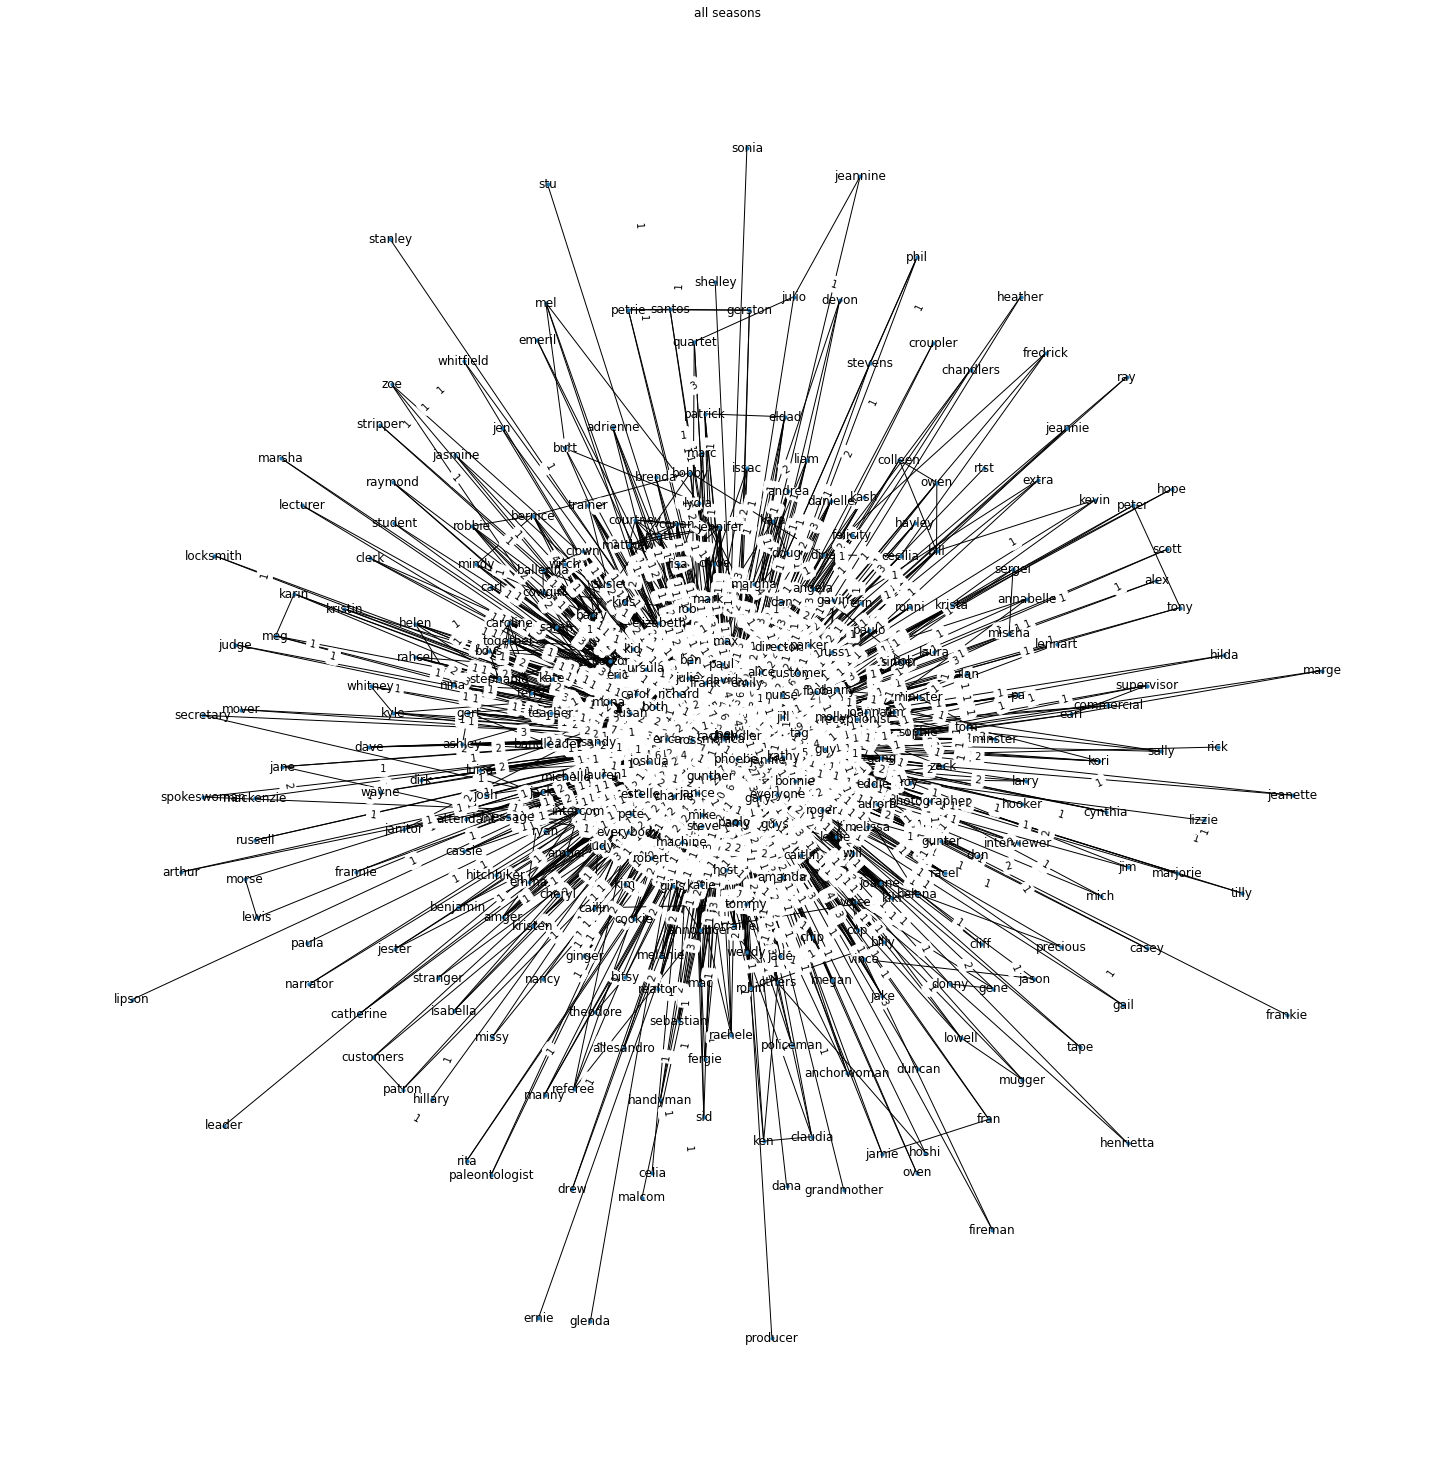

In [77]:
##creates the linkdata dataframe which we use to create the graph with the weight added as each edge's attribute
linkData = pd.DataFrame({'source' : intersection_df['node1'],
                  'target' : intersection_df['node2'],
                  'weight' : intersection_df['weight']})
G_S1 = nx.from_pandas_edgelist(linkData, 'source', 'target', True, nx.Graph())

##removes isolated nodes and random words
G_S1.remove_nodes_from(list(nx.isolates(G_S1)))
random_words_list=['waitress','actor','woman','man','actress','street','waiter','assistant','passenger',
                   'girl','boy','video','tv','radio', 'salesman', 'waiters','housekeeper','dog',
                  'boss','intern','cashier','chandlerdlers','passerby','friend','employee','lady','dream monica','dream joey','all']
G_S1.remove_nodes_from(random_words_list)

##plots the Graph
plt.figure(3,figsize=(20,20)) 
pos=nx.spring_layout(G_S1)
labels = nx.get_edge_attributes(G_S1,'weight')
nx.draw(G_S1,with_labels=True,node_size = 10)
nx.draw_networkx_edge_labels(G_S1,pos,edge_labels=labels)
plt.title('all seasons')

In [78]:
#creates txt file with the edgelist and their weights
nx.write_edgelist(G_S1, "weighted_test_edgelist.txt", delimiter=' ')

In [79]:
G_S1.number_of_nodes()
G_S1.number_of_edges()
print (f'The number of nodes is { G_S1.number_of_nodes()} \nThe number of links is {G_S1.number_of_edges()}')

The number of nodes is 330 
The number of links is 1560


The median of the in degrees is 5


C:\Users\stykaly\AppData\Local\Temp\ipykernel_13476\1781827516.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(len(degree_freq)), degree_freq, 'go-', label='degree', marker='.')


Text(0, 0.5, 'Frequency')

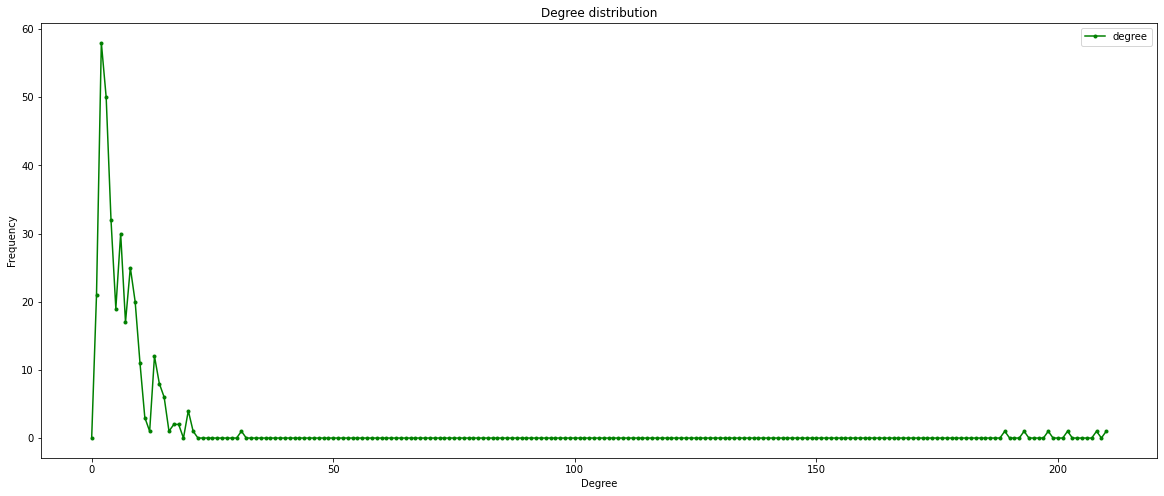

In [80]:
##Finds degree distibution
nodeslist=list(G_S1.nodes())
degrees=list(G_S1.degree(nodeslist))
# Sorts the in-degree matrix from low to high
deg=[]
for i in range (len(degrees)):
    deg.append(degrees[i][1])
list.sort(deg)
print (f'The median of the in degrees is {deg[int(len(deg)/2)]}')

def finds_freq(list1):
    dmax=max(list1)+1
    freq= [ 0 for d in range(dmax) ]
    for d in list1:
        freq[d] += 1
    return freq
degree_freq=finds_freq(deg)



degrees = range(len(degree_freq))
plt.figure(figsize=(20, 8)) 
plt.plot(range(len(degree_freq)), degree_freq, 'go-', label='degree', marker='.') 
plt.title("Degree distribution")
plt.legend(loc="upper right")
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [81]:
   
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)

100%|██████████| 2000/2000 [00:05<00:00, 359.91it/s]


BarnesHut Approximation  took  1.07  seconds
Repulsion forces  took  4.01  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.22  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


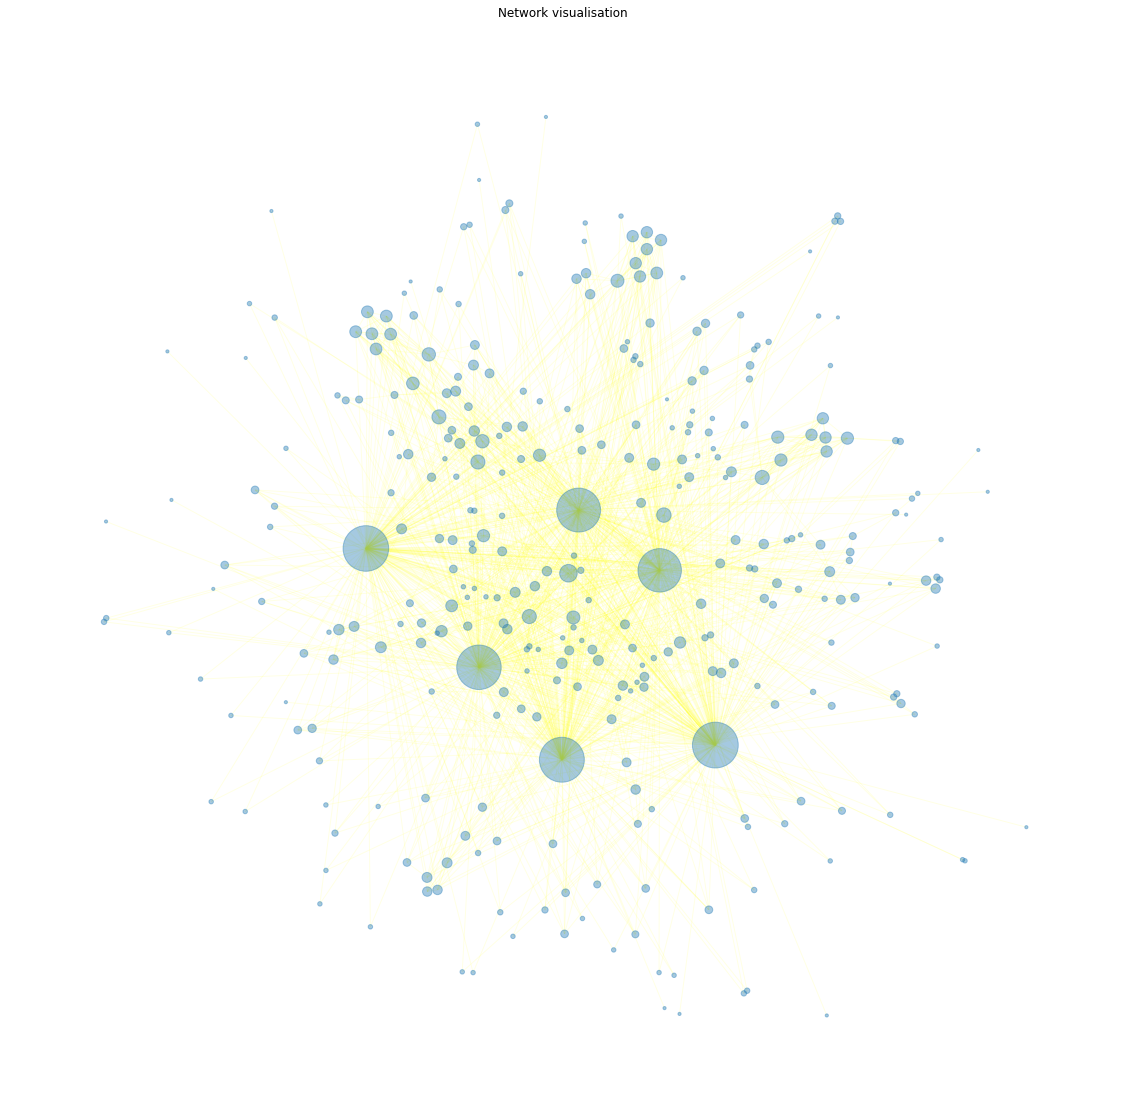

In [82]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.7,

                        # Log
                        verbose=True)

fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_size=custom_size, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title('Network visualisation ')
plt.axis('off')
plt.show()

__Communities__

In [83]:
# First compute the best partition
partition = community.community_louvain.best_partition(G_S1,weight='weight')


size =len(set(partition.values()))

# Find number of communities and print each one's size
print(f'The friends network has {int(size)} communities')

comm_sizes=Counter(partition.values())
community_sizes_list=list(comm_sizes.values())
community_sizes_list.sort()
for i in range (len(community_sizes_list)):
    print(f'Community {i} has size {community_sizes_list[i]}')

# Add 'community' attribute to node 
nx.set_node_attributes(G_S1, partition, name= 'comm')

The friends network has 20 communities
Community 0 has size 2
Community 1 has size 2
Community 2 has size 2
Community 3 has size 2
Community 4 has size 2
Community 5 has size 2
Community 6 has size 2
Community 7 has size 3
Community 8 has size 3
Community 9 has size 4
Community 10 has size 4
Community 11 has size 4
Community 12 has size 6
Community 13 has size 12
Community 14 has size 24
Community 15 has size 25
Community 16 has size 27
Community 17 has size 34
Community 18 has size 37
Community 19 has size 133


In [84]:
color_dictionary={0:'deeppink',
                  1:'purple',
                  2: 'aquamarine',
                  3:'red',
                  4:'blue',
                  5:'orange',
                  6:'coral',
                  7:'green',
                  8:'brown',
                  9:'peachpuff',
                  10:'black',
                  11:'pink',
                  12:'wheat',
                  13:'gray',
                  14:'lightcoral',
                  15:'beige',
                  16:'indigo',
                  17:'lightgreen',
                  18:'indigo',
                  19:'lightgreen',
                  20:'indigo',
                  21:'lightgreen'}

# Creates color list and size list for all the nodes
# Using the 'community' attribute for coloring
community_list=nx.get_node_attributes(G_S1, 'comm')  
nodeslist=list(G_S1.nodes())
custom_color=[]
for i in nodeslist:
    custom_color.append(color_dictionary[community_list[i]])
    
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# Converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)


100%|██████████| 2000/2000 [00:05<00:00, 386.61it/s]


BarnesHut Approximation  took  1.13  seconds
Repulsion forces  took  3.56  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.24  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


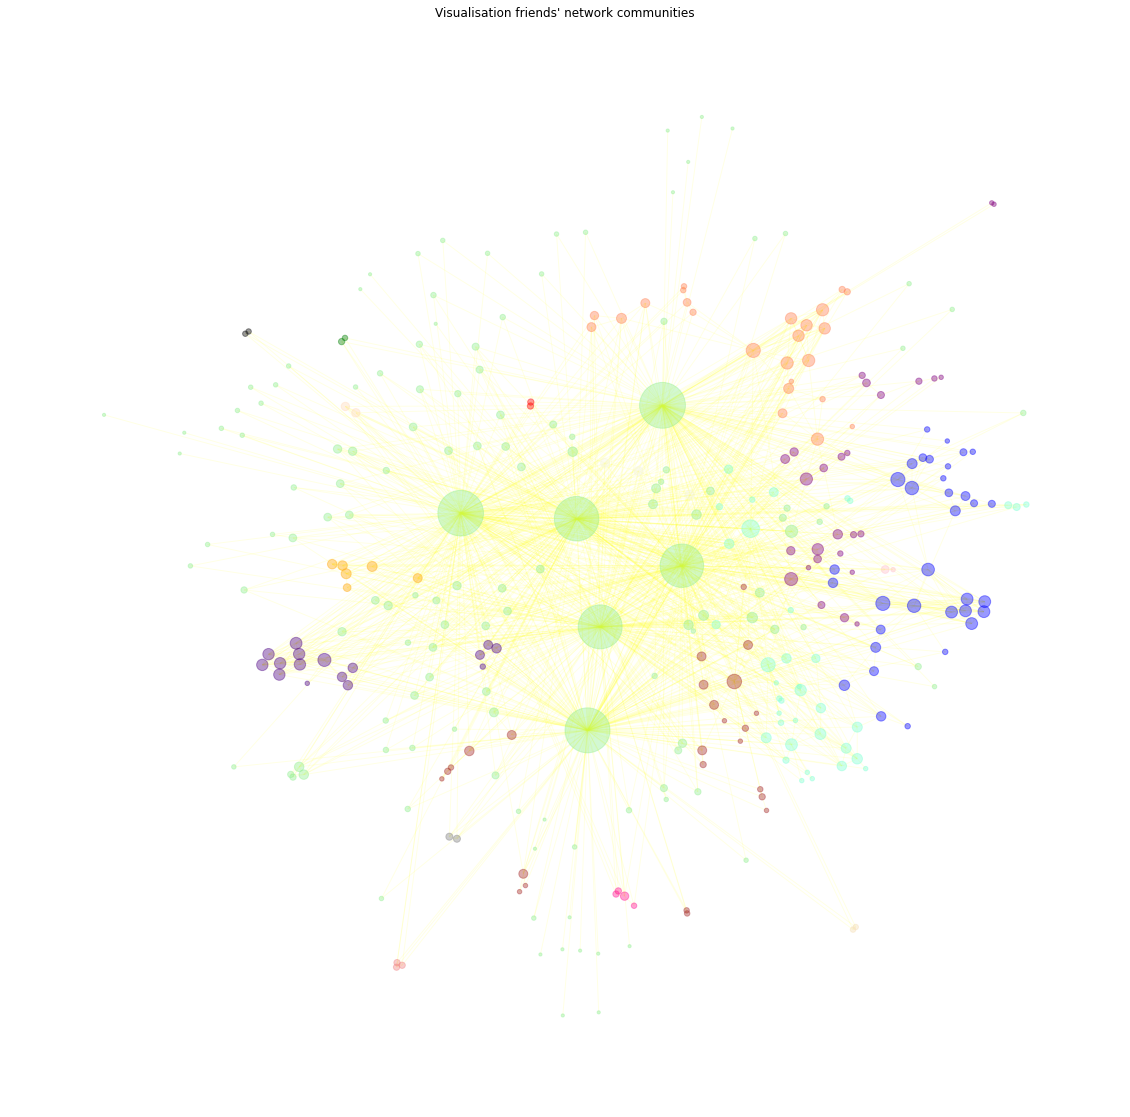

In [85]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=10,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)


fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_color=custom_color, node_size=custom_size, label=nodeslist, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title("Visualisation friends' network communities")
plt.axis('off')
plt.show()

In [86]:
#finds modularity of network
print('The modularity for the network is :',community.modularity(partition, G_S1))

The modularity for the network is : 0.040547421695962045


In [305]:
#creates a df with character and the community they are in (community is identified by the number of nodes it has)
comm_dict=dict(G_S1.nodes(data=True))
df_community= pd.DataFrame(comm_dict)
df_community=df_community.transpose()
df_community.reset_index(inplace=True)
df_community = df_community.rename(columns = {'index':'character'})

# counts the number of nodes in community and puts it in to new dataframe
commune_dict=Counter(df_community['comm'])
df_comm_count = pd.DataFrame(list(commune_dict.items()), columns = ['comm', 'Comm-Count'])
df_community = pd.merge(df_community,df_comm_count, how='inner', on=['comm'])

df_community = df_community.sort_values('Comm-Count', ascending=False)

df_community = df_community[df_community['Comm-Count'] >= 20]
df_community=df_community.reset_index(drop=True)

df_community =df_community.drop(['comm'], axis=1)

print('The cut-off is 20 and the cleaned dataframe contains {} rows.' .format(df_community.shape[0]))

unswapped=dict(df_community.values)
swapped=reverse_non_unique_mapping(unswapped)

for key,value in swapped.items():
    print('\nThe characters of community ' ,key, 'are: ',value)


The cut-off is 20 and the cleaned dataframe contains 280 rows.

The characters of community  133 are:  ['chandler', 'attendant', 'tag', 'hilda', 'mac', 'narrator', 'wayne', 'sebastian', 'dana', 'hillary', 'janine', 'judge', 'alex', 'russell', 'hitchhiker', 'croupler', 'stanley', 'kristen', 'joey', 'jen', 'gary', 'katie', 'krista', 'cynthia', 'danny', 'emeril', 'dave', 'fergie', 'marjorie', 'allesandro', 'casey', 'cheryl', 'erin', 'megan', 'josh', 'catherine', 'mackenzie', 'realtor', 'tape', 'adrienne', 'missy', 'laura', 'glenda', 'dirk', 'chandlers', 'racel', 'handyman', 'sonia', 'extra', 'amy', 'sid', 'jake', 'cliff', 'marc', 'ray', 'parker', 'don', 'will', 'stu', 'hooker', 'stripper', 'brenda', 'kash', 'photographer', 'policeman', 'cassie', 'amanda', 'caitlin', 'kathy', 'shelley', 'duncan', 'stranger', 'frankie', 'paulo', 'julie', 'carl', 'melanie', 'pa', 'danielle', 'celia', 'lorraine', 'ronni', 'roger', 'rick', 'paolo', 'rtst', 'jill', 'director', 'aurora', 'bob', 'janice', 'angela

In [ ]:
## all_text containes all the text from all the seasons as a string
texts_list=list(our_dataframe['text'])
all_text= (" ").join(texts_list)

In [129]:
test_str=our_dataframe['text'][0]

stop_words = set(stopwords.words('english'))

## finds the lines of character and returns a string with the text cleaned
def find_and_clean(character):
    s=re.findall(r'\n\n{}:(.*?)\n\n'.format(character), all_text)
    s_string=' '.join(map(str,s))
    s_string=re.sub(r'[^\w\s]', '',  s_string)
    s_string=re.sub(r'[0-9]',"",s_string)
    text_tokens = word_tokenize(s_string)
    str_no_stopw = [word for word in text_tokens if not word in stop_words]
    s_string= (" ").join(str_no_stopw)
    return s_string

In [134]:
##adds a column with all the character's lines from the show
df_community['text']=list(map(lambda x: find_and_clean(x),df_community['character']))
df_community

,character,Comm-Count,text
0,chandler,133,right joey nice hump hump hairpiece sounds lik...
1,attendant,133,scolding nno running chapel
2,tag,133,thats thats whole name know havent worked offi...
3,hilda,133,thats right dear thank good meeting
4,mac,133,tv well learned one thing today cheese cheerle...
...,...,...,...
275,kara,24,nice meet monica bing slaps chandler butt oww ...
276,stevens,24,never get smacked im telling need smacks got k...
277,karin,24,actually im dating anymore see figured dating ...
278,doug,24,thanks warm welcome good guys team come play h...


In [193]:
#creates a df with communities as keys and their text as value
grouped = df_community.groupby("Comm-Count")

community_dictionary={}
for name, group in grouped:
    text_list=list(group['text'])
    text_string= (" ").join(text_list)
    community_dictionary['{}'.format(name)]=text_string
df_comm_text= pd.DataFrame([community_dictionary])
df_comm_text=df_comm_text.transpose()
df_comm_text.reset_index(inplace=True)
df_comm_text = df_comm_text.rename(columns = {'index':'community'})
df_comm_text = df_comm_text.rename(columns = {0:'text'})
df_comm_text

,community,text
0,24,hi im sally ring assume also single parent har...
1,25,good deal hey hot saves highest force dead ser...
2,27,friends family gathered celebrate today joyous...
3,34,intercom nina bookbinder see intercom still wa...
4,37,hey okay ill get seats yeah oh didnt didnt kno...
5,133,right joey nice hump hump hairpiece sounds lik...


__TF-IDF__

In [204]:
# TF
##Finds tf dictionary of string see reference: http://infolab.stanford.edu/~ullman/mmds/book0n.pdf PAGE 9
def find_tf(text_string):
    tf_dict={}
    text_tokens = word_tokenize(text_string)

    tf_dict = Counter(text_tokens)
    tf_dict=dict(sorted(tf_dict.items(), key=lambda item: item[1],reverse=True))
    tf_dict = {key: value / list(tf_dict.values())[0] for key, value in tf_dict.items()}
    return tf_dict

for i in range (len(df_comm_text['community'])):
    dict1=find_tf(df_comm_text['text'][i])
    n_items = [v for v in list(dict1.keys())[:10]]
    print('Top 10 words used in community {} are: {}'.format(df_comm_text['community'][i],n_items))


Top 10 words used in community 24 are: ['oh', 'well', 'im', 'go', 'dont', 'chandler', 'got', 'know', 'bing', 'yeah']
Top 10 words used in community 25 are: ['im', 'phoebe', 'oh', 'dont', 'yeah', 'like', 'na', 'know', 'youre', 'right']
Top 10 words used in community 27 are: ['ross', 'im', 'oh', 'well', 'know', 'dont', 'yeah', 'okay', 'really', 'go']
Top 10 words used in community 34 are: ['oh', 'well', 'im', 'know', 'yeah', 'dont', 'na', 'uh', 'like', 'thats']
Top 10 words used in community 37 are: ['im', 'oh', 'yeah', 'well', 'dont', 'na', 'youre', 'know', 'phoebe', 'get']
Top 10 words used in community 133 are: ['oh', 'im', 'okay', 'yeah', 'know', 'well', 'dont', 'hey', 'na', 'right']


In [255]:
##IDF

## creates dictionary with the words of string as keys and value 1(exist)
def find_idf(text_string):
    tf_dict={}
    text_tokens = word_tokenize(text_string)

    tf_dict = Counter(text_tokens)
    tf_dict = {key: value / value for key, value in tf_dict.items()}
    return tf_dict


N=len(df_comm_text['community'])
idf_merged=pd.DataFrame()
#for each commnunity text
for i in range (len(df_comm_text['community'])):
    dict1=find_idf(df_comm_text['text'][i]) #applies above function
    
    #creates df with al the words of the community text
    idf_dataframe1= pd.DataFrame([dict1.keys()]) 
    idf_dataframe1=idf_dataframe1.transpose()
    idf_dataframe1.reset_index(inplace=True)
    idf_dataframe1 = idf_dataframe1.rename(columns = {0:'word'})
    
    #appends all the communities words in one dataframe
    idf_merged=pd.concat([idf_merged, idf_dataframe1], ignore_index=True, sort=False)
    
idf_merged =idf_merged.drop(['index'], axis=1)

#finds in how many community texts each word exists by coounting how many times the word appears in the dataframe
idf_merged['freq'] = idf_merged.groupby('word')['word'].transform('count')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
idf_merged =idf_merged.drop_duplicates(subset='word', keep='first')

#applies the idf function to find idf of each word
idf_merged['idf']=list(map(lambda x: np.log2(N/x),idf_merged['freq']))

idf_merged

,word,freq,idf
0,hi,6,0.000000
1,im,6,0.000000
2,sally,1,2.584963
3,ring,6,0.000000
4,assume,2,1.584963
...,...,...,...
24947,minowick,1,2.584963
24948,poecelain,1,2.584963
24949,greyhound,1,2.584963
24950,adlib,1,2.584963


In [266]:
##TF-IDF 
##here we calculate the product of tf x idf in order to see if the top words are more characteristic of the community

for i in range (len(df_comm_text['community'])):
    dict1=find_tf(df_comm_text['text'][i])

    #creates df with al the words of the community text
    tf_dataframe1= pd.DataFrame([dict1]) 
    tf_dataframe1=tf_dataframe1.transpose()
    tf_dataframe1.reset_index(inplace=True)
    tf_dataframe1 = tf_dataframe1.rename(columns = {'index':'word'})
    tf_dataframe1 = tf_dataframe1.rename(columns = {0:'tf'})
    tfidf_dataframe = pd.merge(idf_merged,tf_dataframe1, how='inner', on=['word'])
    tfidf_dataframe =tfidf_dataframe.drop_duplicates(subset='word', keep='first')
    #tfidf_dataframe =tfidf_dataframe.sort_values('tf', ascending=False) #This line is for validation with tf results
    tfidf_dataframe['tf-idf']= tfidf_dataframe.apply(lambda row: (row['idf']*row['tf']),
                                       axis=1)
    tfidf_dataframe =tfidf_dataframe.sort_values('tf-idf', ascending=False)
    tfidf_dataframe = tfidf_dataframe.reset_index(drop=True)
    n_items = list(tfidf_dataframe['word'][:10])
    print('Top 10 words used in community {} are: {}'.format(df_comm_text['community'][i],n_items))



Top 10 words used in community 24 are: ['bing', 'drake', 'dartmouth', 'smacks', 'smelly', 'butt', 'cat', 'erica', 'twins', 'breathe']
Top 10 words used in community 25 are: ['toner', 'gene', 'sergei', 'americcan', 'bakersfield', 'dom', 'touchet', 'gavin', 'henrietta', 'sipowicz']
Top 10 words used in community 27 are: ['emily', 'professor', 'lizzie', 'charlie', 'chicken', 'grade', 'paul', 'thee', 'grant', 'repeat']
Top 10 words used in community 34 are: ['susan', 'mindy', 'farber', 'minsk', 'ben', 'santa', 'sometimes', 'carol', 'intercom', 'katie']
Top 10 words used in community 37 are: ['vic', 'owns', 'jessica', 'hoshi', 'champion', 'product', 'rat', 'fighting', 'kevin', 'beer']
Top 10 words used in community 133 are: ['janice', 'stuff', 'reading', 'moving', 'love', 'naked', 'listens', 'glares', 'dude', 'pheebs']
